## Flood Vulnerability Index (FVI) Assessment 2

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# ------------------------------------------------- #

# District-level Population
df = pd.read_excel('./data/disaster_records/damagedata_DDM.xlsx', 
                   sheet_name='total_population',skiprows=0,skipfooter=0).fillna(0)
popu2017 = df[['ADM2_PCODE', 'Population']]

# Load Vulnerability
vuln = pd.read_hdf('./data/vuln_calculated_adm3.hdf')

## Join 2017 FFWC Flood Forecast and Inundation to Population data

In [2]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()              # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()  # Population Per Pixel (Decuple value)
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple; unit is 10 cm)

In [3]:
# Affected population by Flood Inundation and Flood Forecast
# (a) Flood Inundation      # 1 (Perennial waterbodies), 2 (Flood inundation area)
# *Remove population not in both perennial water and flood inundation
popuInun = popu.copy()
popuInun[~np.isin(inun,[2])] = 0   
# (b) Flood Forecast        # Flood depth (decuple; unit is 10 cm)
# *Affected population increase linearly with flood depth by 3m
popuFcst = popu.copy(); thsd = 35                          
popuFcst[fcst <= thsd] =  popuFcst[fcst <= thsd]*(fcst[fcst <= thsd])**2/thsd**2
popuFcst[fcst < 10] = 0

# popuInun = popuInun /2
# popuFcst = popuFcst /2

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POP'], impact4['POPINUN'], impact4['POPFCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPINUNR'] = afftPopuInun/totlPopu
impact4['POPFCSTR'] = afftPopuFcst/totlPopu
impact4['CELL'], impact4['CELLINUN'], impact4['CELLFCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELLINUNR'] = afftCellInun/totlCell
impact4['CELLFCSTR'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POP','POPINUN','POPFCST','CELL','CELLINUN','CELLFCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPINUNR'] = impact3['POPINUN']/impact3['POP']
impact3['POPFCSTR'] = impact3['POPFCST']/impact3['POP']
impact3['CELLINUNR'] = impact3['CELLINUN']/impact3['CELL']
impact3['CELLFCSTR'] = impact3['CELLFCST']/impact3['CELL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values

# Print
print('POPINUN: {:,}'.format(impact3['POPINUN'].sum().astype(int)))
print('POPFCST: {:,}'.format(impact3['POPFCST'].sum().astype(int)))

POPINUN: 19,642,620
POPFCST: 19,812,664


## Averaged FHV of affected population

In [4]:
# Affected popoulation in Upazila 
impact = impact3.reset_index().drop(['ADM2_PCODE','ADM2_EN','ADM3_EN'], axis=1)
impact['ADM3_PCODE'] = impact['ADM3_PCODE'].astype(int)
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
targ = (impact['ADM3_PCODE']/10000).astype(int) == 45
f45t30 = 300000 + impact.loc[targ, 'ADM3_PCODE'] % 10000
impact.loc[targ, 'ADM3_PCODE'] = f45t30.values
impact['ADM2_PCODE'] = (impact['ADM3_PCODE'] / 100).astype(int)
impact = impact.set_index('ADM3_PCODE')

# Merge impact and vulnerability
merge3 = pd.merge(impact, vuln, how='outer', left_index=True, right_index=True)

# IMPACT ASSESSMENT -------------------------- #
# Averaged FHV = sum(Affected Upazila population * FHV) / Affected District population
# Upazila-level
merge3['EQUALFCST'] = merge3['POPFCST']*merge3['equal']
merge3['SOVIFCST'] = merge3['POPFCST']*merge3['sovi']
merge3['EQUALINUN'] = merge3['POPINUN']*merge3['equal']
merge3['SOVIINUN'] = merge3['POPINUN']*merge3['sovi']
# District-level aggregation
cols = ['POPINUN','POPFCST','EQUALFCST','SOVIFCST','EQUALINUN','SOVIINUN']
merge2 = merge3.groupby('ADM2_PCODE')[cols].sum().reset_index()
# - Import population
merge2 = pd.merge(popu2017, merge2, how='outer',on='ADM2_PCODE')
merge2 = merge2.rename(columns={'Population':'POP'}).set_index('ADM2_PCODE')
# - Calculation
merge2['POPINUNR'] = merge2['POPINUN']/merge2['POP']
merge2['POPFCSTR'] = merge2['POPFCST']/merge2['POP']
merge2['EQUALFCST'] = merge2['EQUALFCST']/(merge2['POPFCST']+1)
merge2['SOVIFCST'] = merge2['SOVIFCST']/(merge2['POPFCST']+1)
merge2['EQUALINUN'] = merge2['EQUALINUN']/(merge2['POPINUN']+1)
merge2['SOVIINUN'] = merge2['SOVIINUN']/(merge2['POPINUN']+1)
# -------------------------------------------- #

# GeoDataFrame
merge3 = merge3.drop('ADM2_PCODE', axis=1)
mapdata3 = shape3.merge(merge3, how='outer', on='ADM3_PCODE')
mapdata2 = shape2.merge(merge2, how='outer', on='ADM2_PCODE')

### Load 2017 flood damage records

In [76]:
damage = pd.read_hdf('./data/impact.hdf',key='data')
damage_table = pd.read_hdf('./data/impact_table.hdf', key='table')
if False:
    name_MinMax = damage_table.loc[damage_table['Normalization'] == 'MinMax','Name']
    if len(name_MinMax) > 0:
        damage[name_MinMax] = MinMaxScaler().fit_transform(damage[name_MinMax])
    name_Quantile = damage_table.loc[damage_table['Normalization'] == 'Quantile','Name']
    if len(name_Quantile) > 0:
        damage[name_Quantile] = QuantileTransformer(n_quantiles=10).fit_transform(damage[name_Quantile])

# Merge Affected population and FHV with damage
cols = ['POP','POPFCST','POPINUN','POPFCSTR','POPINUNR','EQUALFCST','SOVIFCST','EQUALINUN', 'SOVIINUN']
result = pd.merge(merge2[cols], damage, how='inner', left_index=True, right_index=True).reset_index()
result = result.merge(shape2[['ADM2_EN','ADM2_PCODE']], how='inner', left_on='ADM2_PCODE',right_on='ADM2_PCODE')
result = result.drop('ADM2_PCODE', axis=1).set_index('ADM2_EN').reset_index()
# - Number of the reported affected population
result['POPREPO'] = result['PAFFCPOPU']*result['POP']
result.head()

,ADM2_EN,POP,POPFCST,POPINUN,POPFCSTR,POPINUNR,EQUALFCST,SOVIFCST,EQUALINUN,SOVIINUN,...,NDEATH,NDAMGHOUS,DAMGROAD,DAMGCLAND,NAFFCINST,NDAMGTUBE,NTRAUMA,NDIARRHEA,NODIEASE,POPREPO
0,Barguna,896166,71080.1,10785.5,0.079316,0.012035,0.238578,0.272943,0.246163,0.285117,...,0.0,0.0,0.0,0.0,0.0,0.0,1855.0,0.0,0.0,0.0000
1,Brahamanbaria,3148552,1522487.6,820397.6,0.483552,0.260563,0.622776,0.715152,0.633546,0.710846,...,0.0,73.0,308.0,1180.0,6.0,0.0,251.0,0.0,0.0,3778.2624
2,Chandpur,2464091,562719.3,118126.2,0.228368,0.047939,0.518535,0.646095,0.524056,0.658305,...,0.0,1696.0,614.0,57.0,30.0,164.0,0.0,10.0,5.0,5667.4093
3,Comilla,5867340,1123815.0,453139.6,0.191537,0.077231,0.443707,0.524414,0.421839,0.513194,...,2.0,284.0,880.0,3175.0,0.0,0.0,365.0,120.0,0.0,137882.4900
4,Rangamati,628285,0.0,11491.0,0.000000,0.018289,0.000000,0.000000,0.421626,0.488461,...,0.0,3560.0,20.0,2370.0,0.0,0.0,0.0,0.0,0.0,32000.0000


KeyError: 'POP'

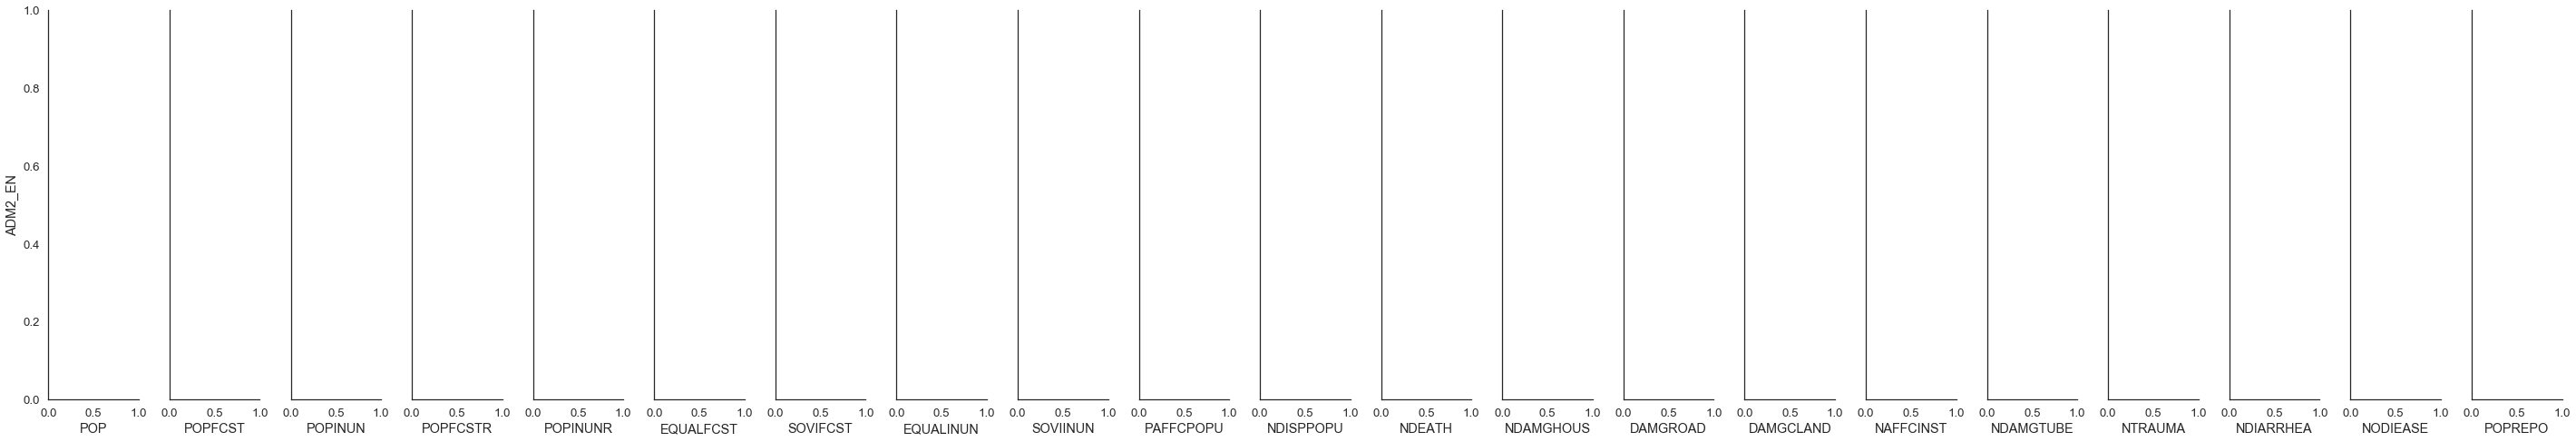

In [74]:
# PairGrid plots
sns.set(style="white", font_scale=1.2)
g = sns.PairGrid(temp, x_vars=result.columns[1:], y_vars=['ADM2_EN'], height=7, aspect=.27)
g.map(sns.barplot, palette='muted')

# Same x axis limits on all columns and add better labels
# g.set(xlim=[0, 1], xticks=[0,0.5,1], xticklabels=[0, 0.5, 1], xlabel='', ylabel='', yticklabels=temp['ADM2_EN'])
g.set(xlim=[0, 0.5], xticks=[0,0.25,0.5], xticklabels=[0, '', 0.5], xlabel='', ylabel='', yticklabels=temp['ADM2_EN'])
# g.axes[0,1].set_xlim(-40,10)
# Title and Grids
for ax, title in zip(g.axes.flat, temp.columns[1:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')

# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout();plt.show()

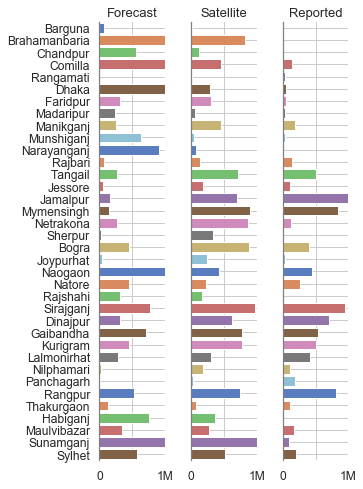

In [95]:
temp = result[['ADM2_EN','POPFCST','POPINUN','POPREPO']]
temp = temp.rename(columns={'POPFCST':'Forecast','POPINUN':'Satellite','POPREPO':'Reported'})
sns.set(style="white", font_scale=1.1)
g = sns.PairGrid(temp, x_vars=temp.columns[1:], y_vars=['ADM2_EN'], height=7, aspect=.25)
g.map(sns.barplot, palette='muted')
g.set(xlim=[0, 1000000], xticks=[0,500000,1000000], xticklabels=[0, '', '1M'], xlabel='', ylabel='', yticklabels=temp['ADM2_EN'])
# Title and Grids
for ax, title in zip(g.axes.flat, temp.columns[1:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')

# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout();plt.show()

## Mapping the results

### (a1) Percentage of affected population (Forecast and Inundation)

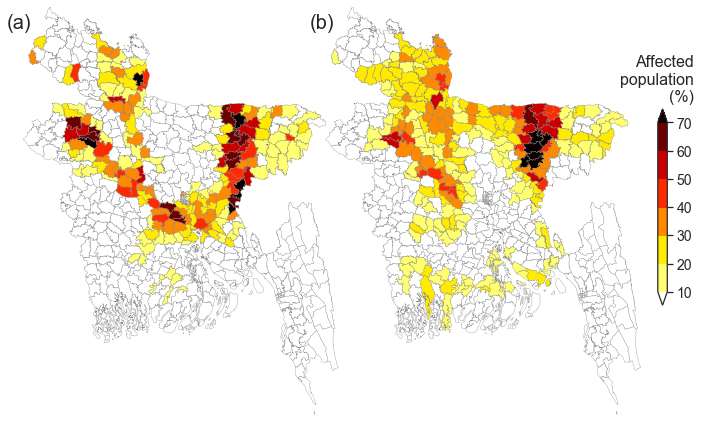

./figures/affected_popu_upazila.png is saved.


In [43]:
# Colormap
bounds = list(np.arange(0.1,0.71,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Affected\npopulation\n(%)'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata3.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                  linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.f'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    
plt.show()

# Save a figure
if True:
    fn_save = './figures/affected_popu_upazila.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### (a2) Percentage of affected population (Forecast, Inundation, and Reported)

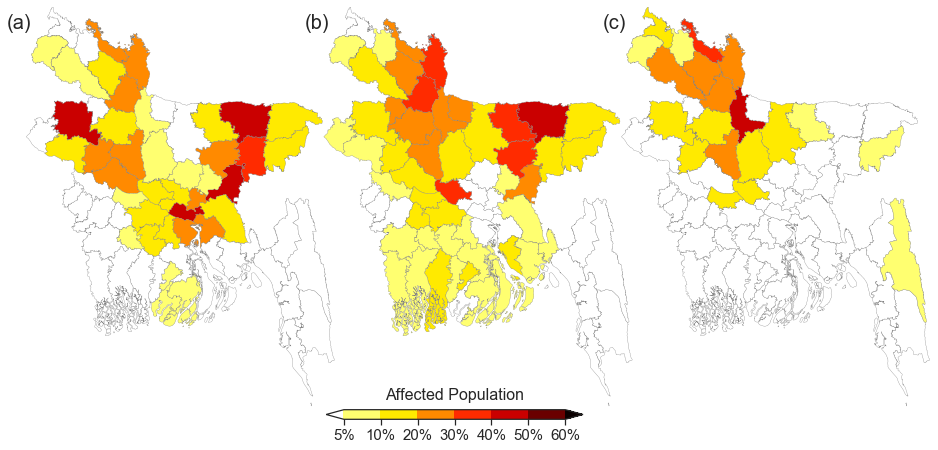

./figures/affected_popu_district.png is saved.


In [44]:
# Import reported percentage of affected population
afftpopu = pd.read_hdf('./data/impact.hdf',key='data').reset_index()[['ADM2_PCODE','PAFFCPOPU']]
mapdata = mapdata2.merge(afftpopu,how='outer',left_on='ADM2_PCODE',right_on='ADM2_PCODE').fillna(0)

# Colormap
# bounds = list(np.arange(0.01,0.51,0.05))
# bounds = [0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
# bounds = [0.01, 0.03, 0.05, 0.1, 0.20, 0.30, 0.40, 0.50]
bounds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# bounds = [0.01, 0.05, 0.1, 0.20, 0.30, 0.40, 0.50, 0.60]
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Affected Population'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR','PAFFCPOPU']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.f%%'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=15)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
plt.show()

# Save a figure
if True:
    fn_save = './figures/affected_popu_district.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### District-level Average FHV of Affected Population

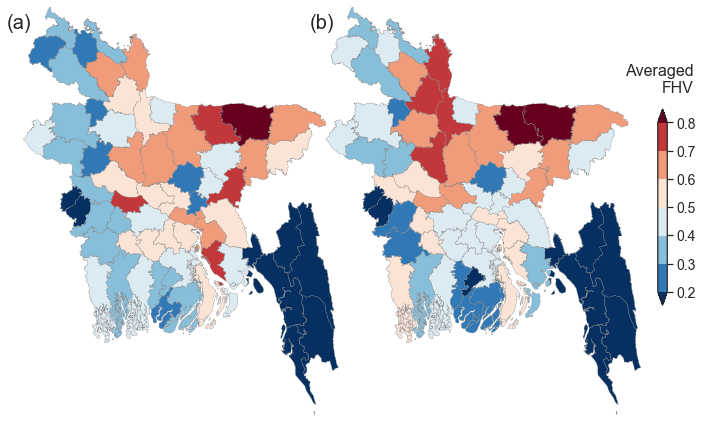

./figures/avg_fhv_district.png is saved.


In [67]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Averaged\nFHV'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['SOVIFCST','EQUALFCST']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata2.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    
plt.show()

# Save a figure
if True:
    fn_save = './figures/avg_fhv_district.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)